In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from model import MNISTNet
from sklearn.metrics import confusion_matrix
import itertools

In [20]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [22]:
def train(model, device, train_loader, val_loader, optimizer, epoch, history):
    model.train()
    total_correct = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        total_correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += target.size(0)

        if batch_idx % 100 == 0:
            train_accuracy = 100. * total_correct / total_samples

            # Run validation and get accuracy
            val_loss, val_accuracy = validate(model, device, val_loader)

            # Store data for visualization
            history["train_loss"].append(loss.item())
            history["train_acc"].append(train_accuracy)
            history["val_acc"].append(val_accuracy)

            # Print output in a single line
            print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)] '
                  f'Loss: {loss.item():.6f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%')

    print(f'Final Training Accuracy: {train_accuracy:.2f}%')

In [24]:
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, accuracy

In [26]:
def test(model, device, test_loader):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({test_accuracy:.2f}%)\n')

In [28]:
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f'Using device: {device}')

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    model = MNISTNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {"train_loss": [], "train_acc": [], "val_acc": []}

    num_epochs = 10
    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, val_loader, optimizer, epoch, history)  # Now history is defined

    print("\nEvaluating on Test Set...")
    test(model, device, test_loader)

    torch.save(model.state_dict(), "mnist_cnn.pt")
    print("Model saved as mnist_cnn.pt")

    # Save history for later visualization
    torch.save(history, "training_history.pt")
    print("Training history saved as training_history.pt")

if __name__ == "__main__":
    main()

Using device: cpu
Epoch 1 [0/48000 (0%)] Loss: 2.318026 | Train Acc: 9.38% | Val Acc: 10.40%
Epoch 1 [6400/48000 (13%)] Loss: 0.241071 | Train Acc: 85.86% | Val Acc: 95.47%
Epoch 1 [12800/48000 (27%)] Loss: 0.038733 | Train Acc: 90.76% | Val Acc: 96.43%
Epoch 1 [19200/48000 (40%)] Loss: 0.046799 | Train Acc: 92.79% | Val Acc: 96.83%
Epoch 1 [25600/48000 (53%)] Loss: 0.063281 | Train Acc: 93.99% | Val Acc: 97.63%
Epoch 1 [32000/48000 (67%)] Loss: 0.032600 | Train Acc: 94.71% | Val Acc: 97.45%
Epoch 1 [38400/48000 (80%)] Loss: 0.023027 | Train Acc: 95.24% | Val Acc: 97.70%
Epoch 1 [44800/48000 (93%)] Loss: 0.218357 | Train Acc: 95.64% | Val Acc: 97.91%
Final Training Accuracy: 95.64%
Epoch 2 [0/48000 (0%)] Loss: 0.151113 | Train Acc: 95.31% | Val Acc: 98.33%
Epoch 2 [6400/48000 (13%)] Loss: 0.009230 | Train Acc: 98.70% | Val Acc: 98.24%
Epoch 2 [12800/48000 (27%)] Loss: 0.047360 | Train Acc: 98.83% | Val Acc: 98.42%
Epoch 2 [19200/48000 (40%)] Loss: 0.004586 | Train Acc: 98.66% | Val Acc

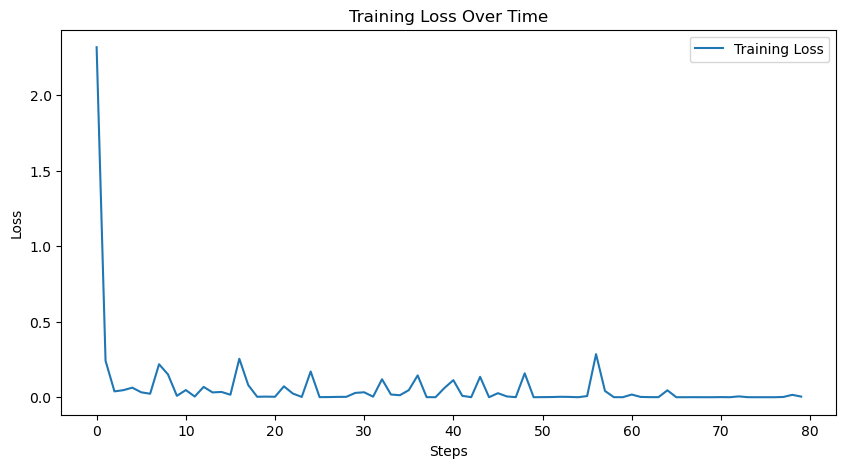

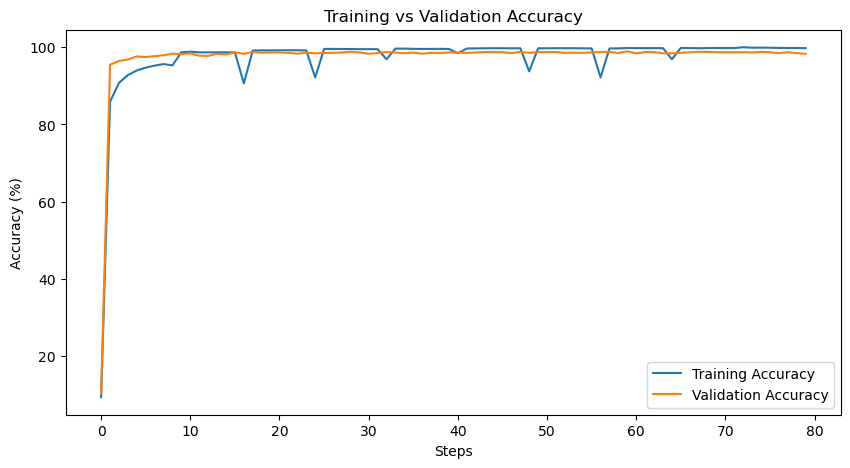

In [32]:
import torch
import matplotlib.pyplot as plt

# Load stored training history
history = torch.load("training_history.pt")

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history["train_acc"], label="Training Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from torchvision.utils import make_grid

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    misclassified_samples = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Loss computation
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # Predictions
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Store predictions and actual labels for confusion matrix
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

            # Store misclassified images
            misclassified_indices = ~pred.eq(target.view_as(pred)).flatten()
            for img, true_label, pred_label in zip(data[misclassified_indices], target[misclassified_indices], pred[misclassified_indices]):
                misclassified_samples.append((img.cpu(), true_label.item(), pred_label.item()))
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    return all_preds, all_targets, misclassified_samples
